In [1]:
# import pandas as pd

# import matplotlib.pyplot as plt

# # File path
# file_path = "/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7/disbond 0.75/disbond 0.75_212.csv"

# # Read the CSV file
# data = pd.read_csv(file_path)

# # Display the first few rows to understand the structure
# print(data.head())

# # Assuming the CSV has two columns: 'x' and 'y' for plotting
# # Replace 'x' and 'y' with the actual column names in your CSV
# x_column = data.columns[0]
# y_column = data.columns[1]

# # Plot the data
# plt.figure(figsize=(10, 6))
# plt.plot(data[x_column], data[y_column], label='Data')
# plt.xlabel(x_column)
# plt.ylabel(y_column)
# plt.title('Plot of CSV Data')
# plt.legend()
# plt.grid()
# plt.show()

<!-- # work from sep 8th  -->

In [3]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from keras import layers 
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import models

sampling_rate = 1600  #Hz
train_size = 0.8
time_period = 10
test_size = 0.1
valid_size = 0.1
random_state = 42
EPOCHS = 10



def process_csv_file(file_path):
    # Function to process a single csv file
    df = pd.read_csv(file_path, header=None, encoding='utf-8')
    
    # Check if the dataframe has at least 2 rows (index 0 and 1)
    if len(df) < 2:
        raise ValueError(f"CSV file {file_path} must have at least 2 rows to contain type_of_damage at row 1")
    
    # Check if row 1 has at least 1 column (index 0)
    if len(df.columns) < 1 or pd.isna(df.iloc[1, 0]):
        raise ValueError(f"CSV file {file_path} is missing type_of_damage value at position [1,0]")
    
    type_of_damage = df.iloc[1, 0]
    time_current_data = df.iloc[2:].astype(float).values
    time_current_pairs = [tuple(row) for row in time_current_data]
    return (time_current_pairs, type_of_damage)





def read_csv_files(path, sampling_rate, period):
    data_for_model = []
    all_data = [] # ((time,current), type, deformation) for each file

    if os.path.isdir(path):
        for root, dirs, files in os.walk(path):
            for filename in files:
                if filename.endswith('.csv'):
                    file_path = os.path.join(root, filename)
                    all_data.append(process_csv_file(file_path))
    elif os.path.isfile(path) and path.endswith('.csv'):
        all_data.append(process_csv_file(path))
    else:
        raise ValueError(f"The path provided is neither a CSV file nor a directory: {path}")

    interval = 1/sampling_rate
    data_for_model = interpolate_data(all_data, interval, period)
    return data_for_model


def interpolate_data(data, interval, period):
    interpolated_data = []

    for time_current_pairs, type_of_damage in data:
        # Extract the time and voltage values
        time, current = zip(*time_current_pairs)

        interpolation_func = interp1d(time, current, kind='linear', fill_value='interpolate')
        max_time = interval * (round(period/interval))
        new_time = np.arange(0, max_time, interval)
        new_time = np.arange(0, max_time, interval)
        new_current = interpolation_func(new_time)

        new_time_current = list(zip(new_time, new_current))
        interpolated_data.append((new_time_current, type_of_damage))
    return interpolated_data
#%%


2025-09-08 17:15:37.194791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:


def extract_data_and_type(data_list):
    new_data = []
    for time_current, damage_type in data_list:
        current_data = [a for _, a in time_current]
        new_data.append((current_data, damage_type))
    return new_data

def normalize_data(data):
    max_val = np.max((np.abs(data)))
    return data / max_val

def convert_to_wave(normalized_data, time_interval):
    sample_rate = tf.cast(int(1/time_interval), tf.int32)

    audio_tensor = tf.convert_to_tensor(normalized_data, dtype=tf.float32)
    audio_tensor = tf.reshape(audio_tensor, (-1,1)) # Ensure correct shape for audio encoding
    return tf.audio.encode_wav(audio_tensor, sample_rate)



def wav_generator(data, sampling_rate):
    classification_data = extract_data_and_type(data)
    # Normalize the data
    normalized_data = [(normalize_data(current_sequence), damage_type) for current_sequence, damage_type in classification_data]
    # Generate WAV files
    time_interval = 1 / sampling_rate
    wav_files = [(convert_to_wave(current_sequence,
                                  time_interval), damage_type)
                 for current_sequence, damage_type in normalized_data]
    return wav_files

In [5]:
def save_wav_files(wav_files, base_folder_path):
    # create a new version of the directory if it already exists
    version = 1
    while os.path.exists(base_folder_path):
        base_folder_path = base_folder_path.rstrip('/')+f"_v{version}"
        version += 1
    # Create a subdirectory for each unique class and save WAV files 
    # it should look like this 
    # main_directory/
    # ...class_a/
    # ......a_audio_1.wav
    # ......a_audio_2.wav
    # ...class_b/
    # ......b_audio_1.wav
    # ......b_audio_2.wav

    for audio_binary, damage_type in wav_files:
        class_directory = os.path.join(base_folder_path, damage_type)

        # create a directory if it doesn't exist
        os.makedirs(class_directory, exist_ok=True)

        # Find the next available file index
        existing_files = os.listdir(class_directory)
        existing_indices = [int(f.split('_')[-1].split('.')[0]) for f in existing_files if f.endswith('.wav')]
        file_index = max(existing_indices, default=0) + 1

        # Define the full path for the new WAV file
        wav_filename = f"{damage_type}_audio_{file_index}.wav"
        wav_filepath = os.path.join(class_directory, wav_filename)

        # write and save the WAV file 
        tf.io.write_file(wav_filepath, audio_binary)
    return base_folder_path

In [6]:
def get_audio_length(directory):
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            for filename in os.listdir(subdir_path):
                if filename.endswith('.wav'):
                    file_path = os.path.join(subdir_path, filename)
                    audio_binary = tf.io.read_file(file_path)
                    waveform, sample_rate = tf.audio.decode_wav(audio_binary)
                    return waveform.shape[0], sample_rate
    return None # case of no audio files 

def num_files(directory):
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        audio_files = [f for f in os.listdir(subdir_path) if f.endswith('.wav')]
        num_files = len(audio_files)
        if num_files > 0:
            return num_files
        else:
            return None

In [7]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram


def make_spec_ds(ds):
    return ds.map(
        map_func=lambda audio,label: (get_spectrogram(audio), label),
        num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
# paths = [
#     '/home/arisenthil/capstone2025_python/data/crushcore_0.75_sep7',
#     '/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7'
# ]

In [ ]:
# data = [read_csv_files(path, sampling_rate, time_period) for path in paths]

In [ ]:
# Get the dimensions and properties of the data
for i, dataset in enumerate(data):
    print(f"Dataset {i+1}:")
    print(f"  Number of entries: {len(dataset)}")
    if len(dataset) > 0:
        print(f"  Type of first entry: {type(dataset[0])}")
        print(f"  Length of first entry: {len(dataset[0]) if hasattr(dataset[0], '__len__') else 'N/A'}")
    print()

Dataset 1:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 2:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 3:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 4:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 5:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 6:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 7:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 8:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 9:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 10:
  Number of entries: 2
  Type of first entry: <class

In [ ]:
raw_data = read_csv_files(path=r"/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7", sampling_rate=sampling_rate, period=time_period)

# Get the dimensions and properties of the data
for i, dataset in enumerate(raw_data):
    print(f"Dataset {i+1}:")
    print(f"  Number of entries: {len(dataset)}")
    if len(dataset) > 0:
        print(f"  Type of first entry: {type(dataset[0])}")
        print(f"  Length of first entry: {len(dataset[0]) if hasattr(dataset[0], '__len__') else 'N/A'}")
    print()

Dataset 1:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 2:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 3:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 4:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 5:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 6:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 7:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 8:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 9:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 10:
  Number of entries: 2
  Type of first entry: <class

In [ ]:
all_data = read_csv_files(path=r"/home/arisenthil/capstone2025_python/data", sampling_rate=sampling_rate, period=time_period)

# Get the dimensions and properties of the data
for i, dataset in enumerate(all_data):
    print(f"Dataset {i+1}:")
    print(f"  Number of entries: {len(dataset)}")
    if len(dataset) > 0:
        print(f"  Type of first entry: {type(dataset[0])}")
        print(f"  Length of first entry: {len(dataset[0]) if hasattr(dataset[0], '__len__') else 'N/A'}")
    print()

Dataset 1:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 2:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 3:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 4:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 5:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 6:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 7:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 8:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 9:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 10:
  Number of entries: 2
  Type of first entry: <class

In [ ]:
paths = [
    '/home/arisenthil/capstone2025_python/data/crushcore_0.75_sep7',
    '/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7'
]

# Method 1: Using a loop to extend the list
data = []
for path in paths:
    data.extend(read_csv_files(path, sampling_rate, period=time_period))

In [ ]:
# Get the dimensions and properties of the data
for i, dataset in enumerate(data):
    print(f"Dataset {i+1}:")
    print(f"  Number of entries: {len(dataset)}")
    if len(dataset) > 0:
        print(f"  Type of first entry: {type(dataset[0])}")
        print(f"  Length of first entry: {len(dataset[0]) if hasattr(dataset[0], '__len__') else 'N/A'}")
    print()

Dataset 1:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 2:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 3:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 4:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 5:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 6:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 7:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 8:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 9:
  Number of entries: 2
  Type of first entry: <class 'list'>
  Length of first entry: 16000

Dataset 10:
  Number of entries: 2
  Type of first entry: <class

In [ ]:
paths = [
    '/home/arisenthil/capstone2025_python/data/crushcore_0.75_sep7',
    '/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7'
]

# Method 1: Using a loop to extend the list
data = []
for path in paths:
    data.extend(read_csv_files(path, sampling_rate, period=time_period))


wav_files = wav_generator(data, sampling_rate)

In [ ]:
wave_folder = os.path.join(os.getcwd(), "wave_files/wave_files")
directory = save_wav_files(wav_files, wave_folder)

In [ ]:
audio_length, sample_rate = get_audio_length(directory)
num_files = num_files(directory)

if audio_length is None:
    raise FileNotFoundError(f"There are no audio files in {directory}")
else:
    print(f"The audio length in {directory} is {audio_length} and the sample rate is {sample_rate}")

if num_files is None:
    raise FileNotFoundError(f"There is an error with the no of files in {directory}")
else:
    print(f"The no of files is {num_files}")

The audio length in /home/arisenthil/capstone2025_python/wave_files/wave_files_v1_v2_v3_v4_v5_v6_v7_v8_v9_v10_v11_v12 is 16000 and the sample rate is 1600
The no of files is 235


In [ ]:


train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = directory,
    batch_size= 1,
    validation_split=0.2,
    seed = 0,
    output_sequence_length= audio_length,
    subset = 'both'
)

Found 480 files belonging to 2 classes.
Using 384 files for training.
Using 96 files for validation.


In [ ]:
label_names = np.array(train_ds.class_names)
print("label names: ", label_names)

train_ds.element_spec

# this dataset contains only a single axis so lets drop the extra axis 

def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis = -1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

# use `Dataset.shard` to split the validation set into two halves.
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)



label names:  ['crushcore 0.75' 'disbond 0.75']


In [ ]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [ ]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
norm_layer = layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label:spec))

2025-09-08 16:46:10.582795: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32,32),
    norm_layer,
    layers.Conv2D(32,3,activation='relu'),
    layers.Conv2D(64,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_5 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,837 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:

history = model.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds, 
    epochs= EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5964 - loss: 0.6787 - val_accuracy: 0.8542 - val_loss: 0.5489
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8229 - loss: 0.4015 - val_accuracy: 0.8750 - val_loss: 0.2185
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9036 - loss: 0.2492 - val_accuracy: 0.9792 - val_loss: 0.1738
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9453 - loss: 0.1800 - val_accuracy: 0.9792 - val_loss: 0.0882
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9792 - loss: 0.0714 - val_accuracy: 0.9792 - val_loss: 0.0356
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0375 - val_accuracy: 1.0000 - val_loss: 0.0055
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0353 - val_accuracy: 1.0000 - val_loss: 0.0053
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9818 - loss: 0.0417 - val_accuracy: 0.

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Text(0, 0.5, 'Accuracy [%]')

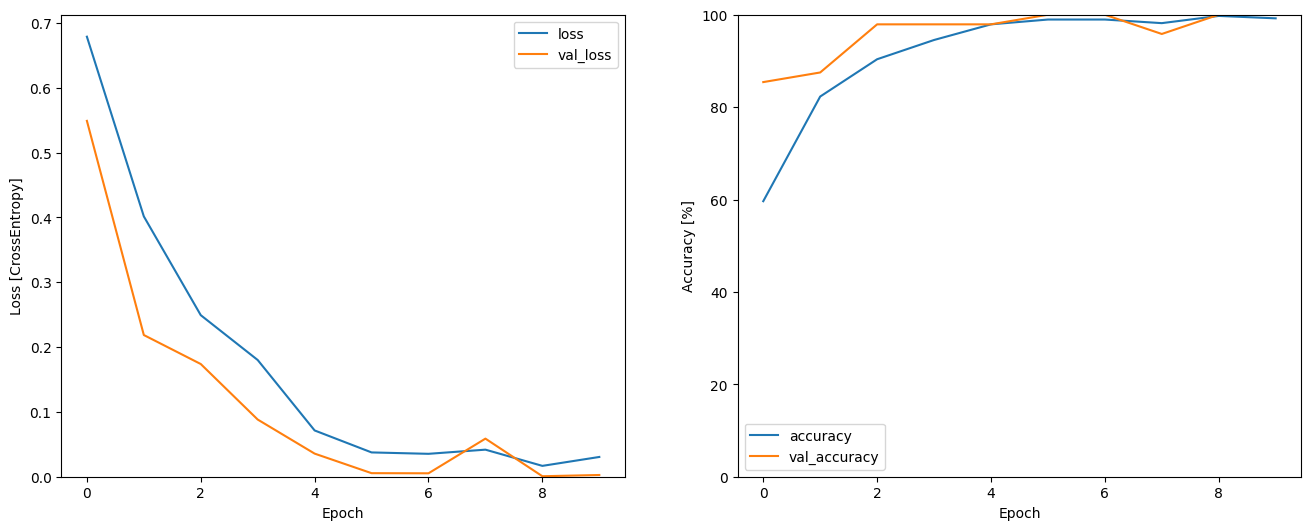

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

14/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0046    

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0030
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


2025-09-08 16:49:31.277374: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


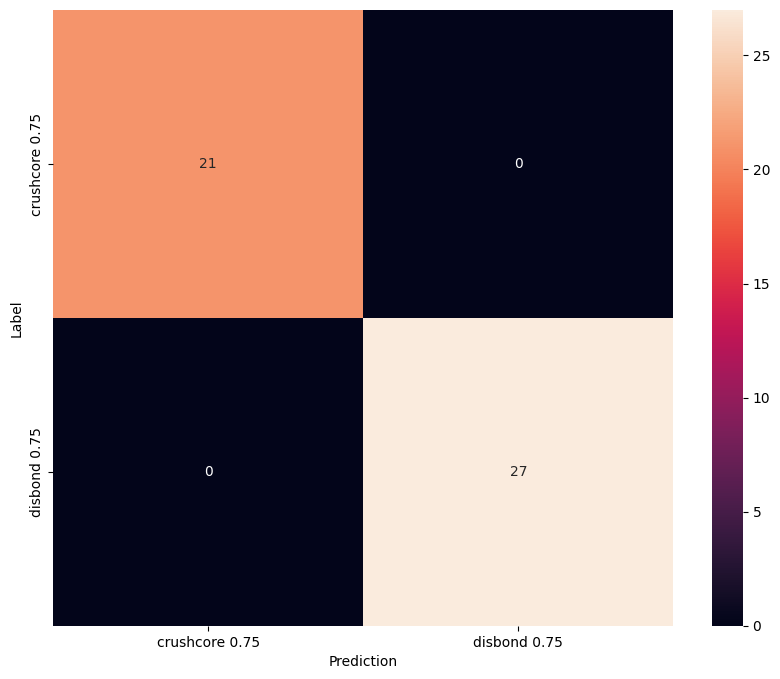

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch.
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it.
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]

        x = get_spectrogram(x)
        result = self.model(x, training=False)

        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
                'class_ids': class_ids,
                'class_names': class_names}

In [ ]:
model_name = ExportModel(model)
save_model_directory = os.path.join(os.getcwd(), "saved_models")

# Create the directory if it doesn't exist
os.makedirs(save_model_directory, exist_ok=True)

# Use a string for the model name, not the object
model_path = os.path.join(save_model_directory, "audio_classifier_model")

# Save the model using the ExportModel object and the path string
tf.saved_model.save(model_name, model_path)

INFO:tensorflow:Assets written to: /home/arisenthil/capstone2025_python/saved_models/audio_classifier_model/assets


INFO:tensorflow:Assets written to: /home/arisenthil/capstone2025_python/saved_models/audio_classifier_model/assets


In [9]:
def train_audio_classification_model(data_paths, model_save_name, sampling_rate=16000, time_period=10, epochs=10):
    """
    Train an audio classification model from CSV data and save it.
    
    Args:
        data_paths (list): List of paths to directories containing CSV files
        model_save_name (str): Name for the saved model (without extension)
        sampling_rate (int): Audio sampling rate (default: 16000)
        time_period (float): Time period for audio generation (default: 10)
        epochs (int): Number of training epochs (default: 10)
    
    Returns:
        tuple: (model, history, save_path) - The trained model, training history, and save path
    """
    
    # Flatten data from multiple paths
    print("Loading data from paths...")
    data = []
    for path in data_paths:
        data.extend(read_csv_files(path, sampling_rate, period=time_period))
    
    # Generate wav files
    print("Generating wav files...")
    wav_files = wav_generator(data, sampling_rate)
    
    # Save wav files
    wave_folder = os.path.join(os.getcwd(), "wave_files/wave_files")
    directory = save_wav_files(wav_files, wave_folder)
    
    # Get audio properties
    print("Analyzing audio files...")
    audio_length, sample_rate = get_audio_length(directory)
    num_files_count = num_files(directory)
    
    if audio_length is None:
        raise FileNotFoundError(f"There are no audio files in {directory}")
    else:
        print(f"The audio length in {directory} is {audio_length} and the sample rate is {sample_rate}")
    
    if num_files_count is None:
        raise FileNotFoundError(f"There is an error with the no of files in {directory}")
    else:
        print(f"The no of files is {num_files_count}")
    
    # Create datasets
    print("Creating TensorFlow datasets...")
    train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
        directory=directory,
        batch_size=1,
        validation_split=0.2,
        seed=0,
        output_sequence_length=audio_length,
        subset='both'
    )
    
    label_names = np.array(train_ds.class_names)
    print("Label names: ", label_names)
    
    # Squeeze extra dimensions
    def squeeze(audio, labels):
        audio = tf.squeeze(audio, axis=-1)
        return audio, labels
    
    train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
    val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
    
    # Split validation set
    test_ds = val_ds.shard(num_shards=2, index=0)
    val_ds = val_ds.shard(num_shards=2, index=1)
    
    # Create spectrogram datasets
    print("Creating spectrogram datasets...")
    train_spectrogram_ds = make_spec_ds(train_ds)
    val_spectrogram_ds = make_spec_ds(val_ds)
    test_spectrogram_ds = make_spec_ds(test_ds)
    
    # Get input shape
    for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
        break
    input_shape = example_spectrograms.shape[1:]
    num_labels = len(label_names)
    
    # Optimize datasets
    train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
    val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
    test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
    
    # Create normalization layer
    norm_layer = layers.Normalization()
    norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
    
    # Build model
    print("Building model...")
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        norm_layer,
        layers.Conv2D(32, 3, activation='relu'),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_labels),
    ])
    
    model.summary()
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'],
    )
    
    # Train model
    print("Training model...")
    history = model.fit(
        train_spectrogram_ds,
        validation_data=val_spectrogram_ds,
        epochs=epochs,
        callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
    )
    
    # Test model
    print("Testing model...")
    y_pred = model.predict(test_spectrogram_ds)
    
    # Create export model class
    class ExportModel(tf.Module):
        def __init__(self, model):
            self.model = model
            # Accept either a string-filename or a batch of waveforms.
            self.__call__.get_concrete_function(
                x=tf.TensorSpec(shape=(), dtype=tf.string))
            self.__call__.get_concrete_function(
                x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
        
        @tf.function
        def __call__(self, x):
            # If they pass a string, load the file and decode it.
            if x.dtype == tf.string:
                x = tf.io.read_file(x)
                x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
                x = tf.squeeze(x, axis=-1)
                x = x[tf.newaxis, :]
            
            x = get_spectrogram(x)
            result = self.model(x, training=False)
            class_ids = tf.argmax(result, axis=-1)
            class_names = tf.gather(label_names, class_ids)
            return {
                'predictions': result,
                'class_ids': class_ids,
                'class_names': class_names
            }
    
    # Save model
    print(f"Saving model as '{model_save_name}'...")
    export_model = ExportModel(model)
    save_model_directory = os.path.join(os.getcwd(), "saved_models")
    os.makedirs(save_model_directory, exist_ok=True)
    model_path = os.path.join(save_model_directory, model_save_name)
    tf.saved_model.save(export_model, model_path)
    
    print(f"Model saved successfully to: {model_path}")
    
    return {
        'model': model,
        'history': history,
        'model_path': model_path,
        'test_spectrogram_ds': test_spectrogram_ds,
        'label_names': label_names,
        'train_spectrogram_ds': train_spectrogram_ds,
        'val_spectrogram_ds': val_spectrogram_ds
    }

In [ ]:
paths = [
    '/home/arisenthil/capstone2025_python/data/crushcore_0.75_sep7',
    '/home/arisenthil/capstone2025_python/data/disbond_0.75_sep7'
]

results = train_audio_classification_model(
    data_paths=paths,
    model_save_name="classifier_model",
    epochs=10
)

Loading data from paths...
Generating wav files...


I0000 00:00:1757369785.343981   57577 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2787 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Analyzing audio files...
The audio length in /home/arisenthil/capstone2025_python/wave_files/wave_files is 160000 and the sample rate is 16000
The no of files is 235
Creating TensorFlow datasets...
Found 480 files belonging to 2 classes.
Using 384 files for training.
Using 96 files for validation.
Label names:  ['crushcore 0.75' 'disbond 0.75']
Creating spectrogram datasets...


2025-09-08 17:16:39.480593: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Building model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,624,837 (6.20 MB)

 Trainable params: 1,624,834 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Training model...
Epoch 1/10


2025-09-08 17:16:42.726919: I external/local_xla/xla/service/service.cc:163] XLA service 0x7d7e94001a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-08 17:16:42.726954: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 Ti, Compute Capability 7.5
2025-09-08 17:16:42.775223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-08 17:16:43.131791: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-08 17:16:43.756147: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,30,30]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cu

 33/384 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6205 - loss: 1.2858

I0000 00:00:1757369806.165497   57696 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5918 - loss: 0.8135

2025-09-08 17:16:49.141552: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1,64,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32,30,30]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}


384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.6823 - loss: 0.6284 - val_accuracy: 0.5417 - val_loss: 1.0081
Epoch 2/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8984 - loss: 0.2403 - val_accuracy: 1.0000 - val_loss: 0.0819
Epoch 3/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9740 - loss: 0.0780 - val_accuracy: 1.0000 - val_loss: 0.0200
Epoch 4/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9792 - loss: 0.0497 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 5/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9740 - loss: 0.0622 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 6/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9818 - loss: 0.0517 - val_accuracy: 1.0000 - val_loss: 0.0032
Epoch 7/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9948 - loss: 0.0137 - val_accuracy: 1.0000 - val_loss: 6.5342e-04
Epoch 8/10
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 -

INFO:tensorflow:Assets written to: /home/arisenthil/capstone2025_python/saved_models/classifier_model/assets


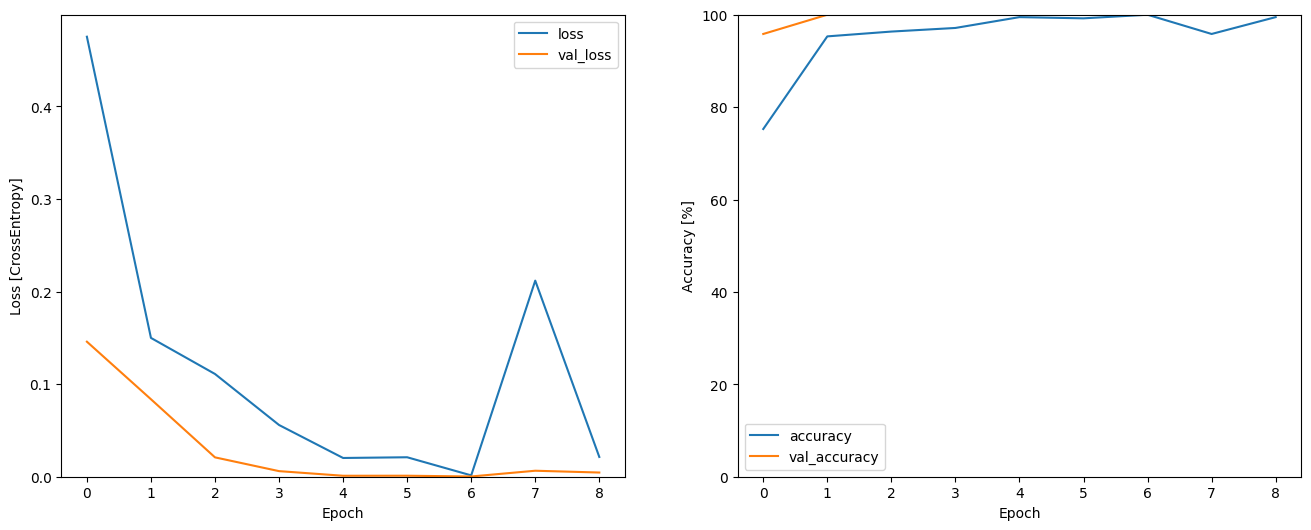

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7917 - loss: 0.9874
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


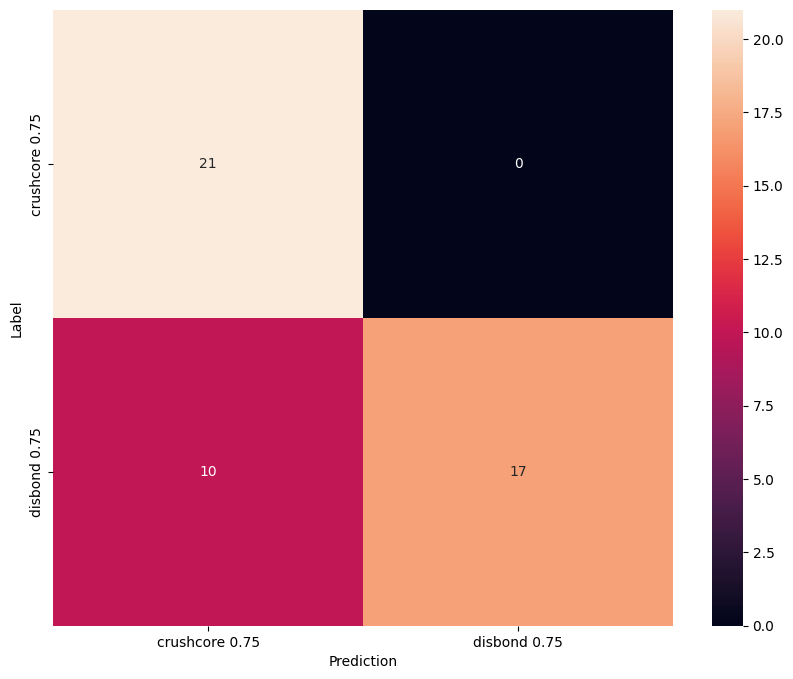

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.show()

# Evaluate model and create confusion matrix
model.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Text(0, 0.5, 'Accuracy [%]')

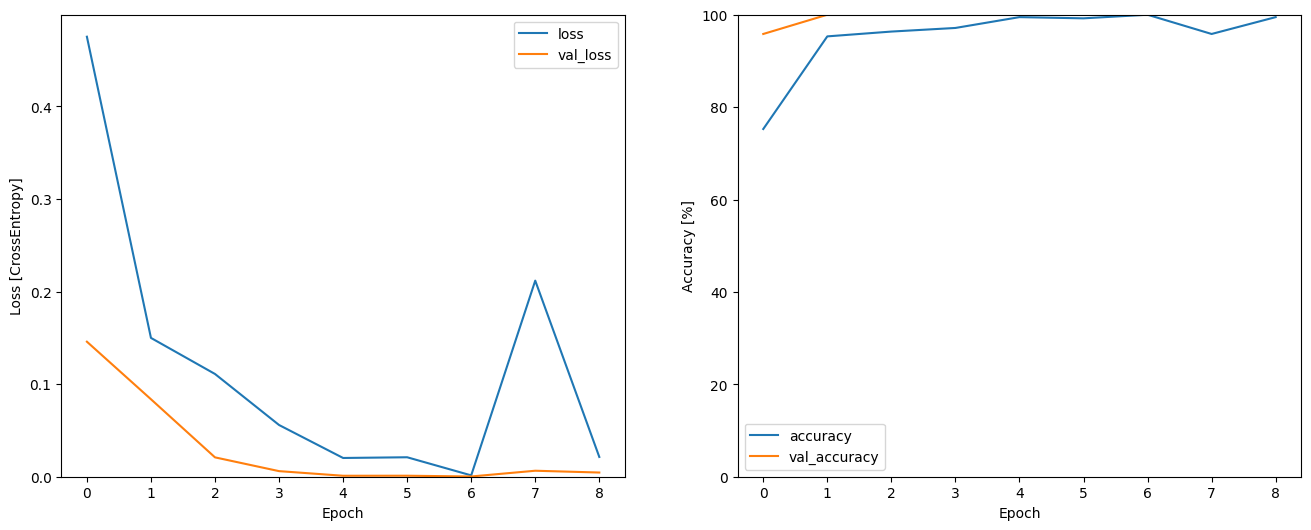

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


model.evaluate(test_spectrogram_ds, return_dict=True)

y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
# folders = [folder for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]
# print("Folders in data_path:", folders)

Folders in data_path: ['crushcore_0.75_sep7', 'disbond_0.75_sep7']


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from matplotlib.backends.backend_pdf import PdfPages
from datetime import datetime
import openai
import io
import base64
from PIL import Image

def generate_model_report_pdf(results, report_filename="classification_report.pdf", openai_api_key=None):
    """
    Generate a comprehensive PDF report with training metrics and AI-generated analysis.
    
    Args:
        results (dict): Dictionary returned from train_classification_model()
        report_filename (str): Name of the output PDF file
        openai_api_key (str): OpenAI API key for generating analysis text
    
    
    Returns:
        str: Path to the generated PDF report
    """
    
    # Extract components from results
    model = results['model']
    history = results['history']
    model_path = results['model_path']
    test_spectrogram_ds = results['test_spectrogram_ds']
    label_names = results['label_names']
    
    # Set up OpenAI client if API key provided
    if openai_api_key:
        openai.api_key = openai_api_key
    
    # Create PDF
    with PdfPages(report_filename) as pdf:
        
        # Page 1: Training Metrics
        fig = plt.figure(figsize=(16, 10))
        fig.suptitle('Classification Model Training Report', fontsize=20, fontweight='bold')
        
        # Get metrics
        metrics = history.history
        
        # Loss plot
        plt.subplot(2, 2, 1)
        plt.plot(history.epoch, metrics['loss'], 'b-', linewidth=2, label='Training Loss')
        plt.plot(history.epoch, metrics['val_loss'], 'r-', linewidth=2, label='Validation Loss')
        plt.legend()
        plt.ylim([0, max(max(metrics['loss']), max(metrics['val_loss'])) * 1.1])
        plt.xlabel('Epoch')
        plt.ylabel('Loss [CrossEntropy]')
        plt.title('Training and Validation Loss')
        plt.grid(True, alpha=0.3)
        
        # Accuracy plot
        plt.subplot(2, 2, 2)
        plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 'b-', linewidth=2, label='Training Accuracy')
        plt.plot(history.epoch, 100*np.array(metrics['val_accuracy']), 'r-', linewidth=2, label='Validation Accuracy')
        plt.legend()
        plt.ylim([0, 100])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy [%]')
        plt.title('Training and Validation Accuracy')
        plt.grid(True, alpha=0.3)
        
        # Model evaluation
        eval_results = model.evaluate(test_spectrogram_ds, return_dict=True, verbose=0)
        
        # Add text summary
        plt.subplot(2, 1, 2)
        plt.axis('off')
        
        # Create summary text
        final_train_acc = metrics['accuracy'][-1] * 100
        final_val_acc = metrics['val_accuracy'][-1] * 100
        test_acc = eval_results['accuracy'] * 100
        test_loss = eval_results['loss']
        
        summary_text = f"""
        MODEL TRAINING SUMMARY
        
        Training Configuration:
        • Number of Epochs: {len(history.epoch)}
        • Number of Classes: {len(label_names)}
        • Class Names: {', '.join(label_names)}
        
        Final Performance:
        • Final Training Accuracy: {final_train_acc:.2f}%
        • Final Validation Accuracy: {final_val_acc:.2f}%
        • Test Accuracy: {test_acc:.2f}%
        • Test Loss: {test_loss:.4f}
        
        Model Information:
        • Model saved at: {model_path}
        • Total Parameters: {model.count_params():,}
        • Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
        """
        
        plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 2: Confusion Matrix
        fig, ax = plt.subplots(figsize=(12, 10))
        
        # Generate predictions for confusion matrix
        y_pred = model.predict(test_spectrogram_ds, verbose=0)
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.concat(list(test_spectrogram_ds.map(lambda s, lab: lab)), axis=0)
        confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
        
        # Create confusion matrix heatmap
        sns.heatmap(confusion_mtx.numpy(),
                   xticklabels=label_names,
                   yticklabels=label_names,
                   annot=True, fmt='g',
                   cmap='Blues',
                   ax=ax)
        ax.set_xlabel('Predicted Label', fontsize=14)
        ax.set_ylabel('True Label', fontsize=14)
        ax.set_title('Confusion Matrix - Test Set Performance', fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close()
        
        # Page 3: AI-Generated Analysis (if OpenAI API key provided)
        if openai_api_key:
            try:
                # Prepare data for AI analysis
                analysis_prompt = f"""
                Analyze the following classification model training results and provide insights:
                
                Training Results:
                - Number of epochs: {len(history.epoch)}
                - Classes: {list(label_names)}
                - Final training accuracy: {final_train_acc:.2f}%
                - Final validation accuracy: {final_val_acc:.2f}%
                - Test accuracy: {test_acc:.2f}%
                - Test loss: {test_loss:.4f}
                - Training loss progression: {[f'{loss:.4f}' for loss in metrics['loss']]}
                - Validation loss progression: {[f'{loss:.4f}' for loss in metrics['val_loss']]}
                - Training accuracy progression: {[f'{acc:.4f}' for acc in metrics['accuracy']]}
                - Validation accuracy progression: {[f'{acc:.4f}' for acc in metrics['val_accuracy']]}
                
                Confusion Matrix (rows=true labels, cols=predicted labels):
                {confusion_mtx.numpy().tolist()}
                
                Please provide:
                1. Overall model performance assessment
                2. Analysis of overfitting/underfitting
                3. Class-specific performance insights
                4. Recommendations for improvement
                5. Training stability analysis
                
                Format the response as a professional technical report.
                """
                
                # Generate AI analysis using OpenAI
                response = openai.ChatCompletion.create(
                    model="gpt-5",
                    messages=[
                        {"role": "system", "content": "You are an expert machine learning engineer analyzing classification model results."},
                        {"role": "user", "content": analysis_prompt}
                    ],
                    max_tokens=1500,
                    temperature=0.3
                )
                
                ai_analysis = response.choices[0].message.content
                
                # Create AI analysis page
                fig, ax = plt.subplots(figsize=(11, 8.5))
                ax.axis('off')
                
                ax.text(0.05, 0.95, "AI-GENERATED MODEL ANALYSIS", 
                       transform=ax.transAxes, fontsize=16, fontweight='bold')
                
                ax.text(0.05, 0.05, ai_analysis,
                       transform=ax.transAxes, fontsize=10,
                       verticalalignment='bottom',
                       wrap=True,
                       bbox=dict(boxstyle='round,pad=1', facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.close()
                
            except Exception as e:
                print(f"Warning: Could not generate AI analysis. Error: {str(e)}")
                # Create a simple analysis page without AI
                fig, ax = plt.subplots(figsize=(11, 8.5))
                ax.axis('off')
                
                basic_analysis = f"""
                BASIC MODEL ANALYSIS
                
                Performance Summary:
                • The model achieved {test_acc:.2f}% accuracy on the test set
                • Training converged after {len(history.epoch)} epochs
                • {'Potential overfitting detected' if final_train_acc - final_val_acc > 10 else 'Good generalization observed'}
                
                Recommendations:
                • Monitor for overfitting if training accuracy significantly exceeds validation accuracy
                • Consider data augmentation if more training data is needed
                • Evaluate per-class performance using the confusion matrix
                • Consider hyperparameter tuning for improved performance
                
                Note: AI analysis unavailable - check OpenAI API key and connection.
                """
                
                ax.text(0.05, 0.95, basic_analysis,
                       transform=ax.transAxes, fontsize=12,
                       verticalalignment='top',
                       bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))
                
                plt.tight_layout()
                pdf.savefig(fig, bbox_inches='tight')
                plt.close()
    
    print(f"Report generated successfully: {report_filename}")
    return report_filename

# Example usage function
def create_comprehensive_report(results, use_openai=True):
    """
    Convenience function to create plots and generate PDF report.
    
    Args:
        results (dict): Results dictionary from train_classification_model()
        use_openai (bool): Whether to use OpenAI API for enhanced analysis
    """
    
    # Extract components
    model = results['model']
    history = results['history']
    test_spectrogram_ds = results['test_spectrogram_ds']
    label_names = results['label_names']
    
    # Display plots interactively first
    metrics = history.history
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
    plt.legend(['loss', 'val_loss'])
    plt.ylim([0, max(plt.ylim())])
    plt.xlabel('Epoch')
    plt.ylabel('Loss [CrossEntropy]')
    
    plt.subplot(1,2,2)
    plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
    plt.legend(['accuracy', 'val_accuracy'])
    plt.ylim([0, 100])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy [%]')
    plt.show()
    
    # Evaluate model and create confusion matrix
    model.evaluate(test_spectrogram_ds, return_dict=True)
    y_pred = model.predict(test_spectrogram_ds)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=label_names,
                yticklabels=label_names,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
    
    # Generate PDF report
    report_path = generate_model_report_pdf(results, use_openai=use_openai)
    return report_path

In [ ]:
report_path = generate_model_report_pdf(
    results, 
    report_filename="my_audio_model_report.pdf",
    use_openai=True
)

TypeError: generate_model_report_pdf() got an unexpected keyword argument 'use_openai'